## Mandelbrot

In this tutorial, we will take a look at complex numbers and one of their applications. We will try to figure out on how to compute a simple mandelbrot. Lets`s start with a simple example on how python handles complex numbers.

Let's start with a basic Python Mandelbrot set. We use numpy arrays for the image and display it using pylab imshow.

In [1]:
from PIL import Image
import numpy as np
from numba import autojit
from timeit import default_timer as timer
from skimage import data, exposure

The following few lines just briefly demonstrate on how to use complex numbers in python.

In [2]:
x = 1
y = 1

z = complex(x,y)

In [3]:
print z

(1+1j)


In [4]:
print z.real

1.0


In [5]:
print z.imag

1.0


The complex plane

In [6]:
from matplotlib import pylab as plt

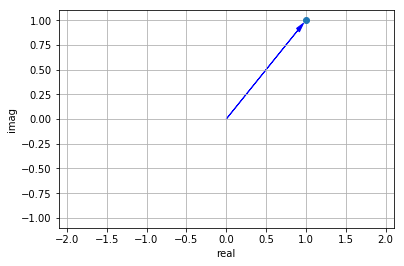

In [7]:
plt.figure(figsize = (6,4))
plt.grid()
plt.plot(z.real, z.imag, "o")
plt.arrow(0,0, z.real-0.1, z.imag-0.1, 
              head_width=0.05, 
              head_length=0.1, 
              fc='b',
              ec='b')
plt.xlim([-2.1,+2.1])
plt.ylim([-1.1,+1.1])
plt.xlabel("real")
plt.ylabel("imag")

plt.show()

## Mandelbrot computation

The following function computes a mandelbrot set for a given point in the complex plane $z = x + yj$. It returns the number of iterations before the computation "escapes".

In [8]:
def Mandel(x,y, itter = 1, thresh = 4):
    c = complex(x,y)
    z = 0.0j
    
    for i in range(itter):

        z = z**2+c
        if (z.real**2. + z.imag**2) >=thresh:
            return i
        
    return itter

The following function performs a mandelbrot set calculation for a given set of points within a 2D array. It also scales between pixel space and complex space. It returns a 2D numpy array. With this function we can produce a single mandlebrot set by giving it the image dimensions, a cutoff value and the number of maximum iterations.

In [9]:
def draw_Mandel(min_x, max_x, min_y, max_y, image, iters, thresh):
      
        
      height = image.shape[0]  ### frame dimension y
      width  = image.shape[1]  ### frame dimension x
    
      pixel_size_x = (max_x - min_x) / width  ### pixel dimension x
      pixel_size_y = (max_y - min_y) / height ### pixel dimesnion y

      for x in range(width):
            real = min_x + x * pixel_size_x
            for y in range(height):
                  imag  = min_y + y * pixel_size_y
                  color = Mandel(real, imag, iters, thresh)
                  image[y, x] = color
      return image

To make the mandelbrot computation a little bit more interesting, we can generate a number of images while zooming in after the 20th iteration. We will also use the timeit module to determin the time it takes to compute the individual sets. 

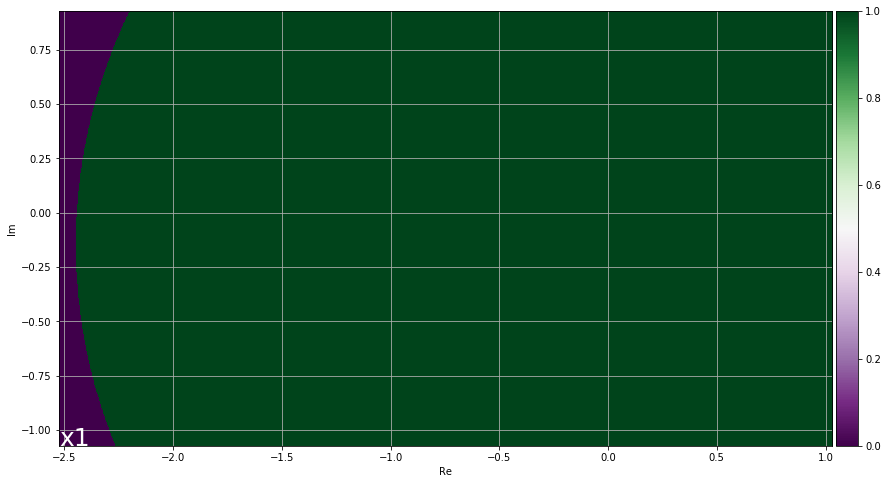

time to compute 1 iterations: 5.97573208809s


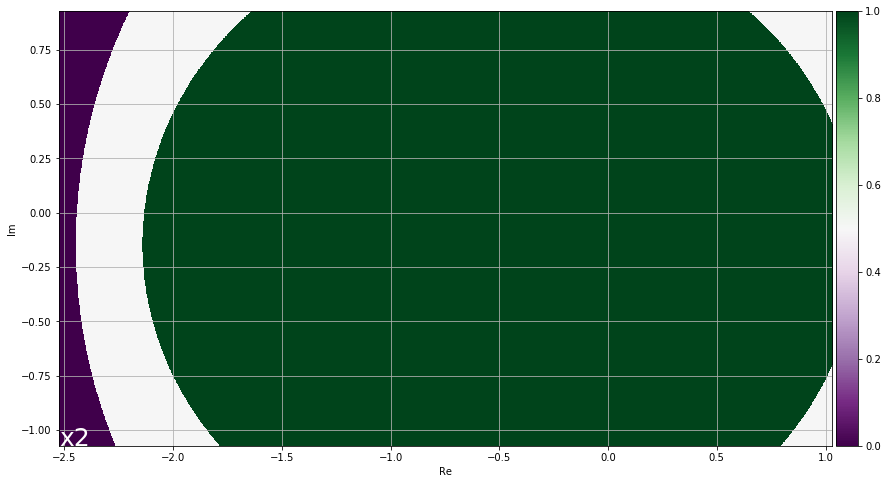

time to compute 2 iterations: 7.04559588432s


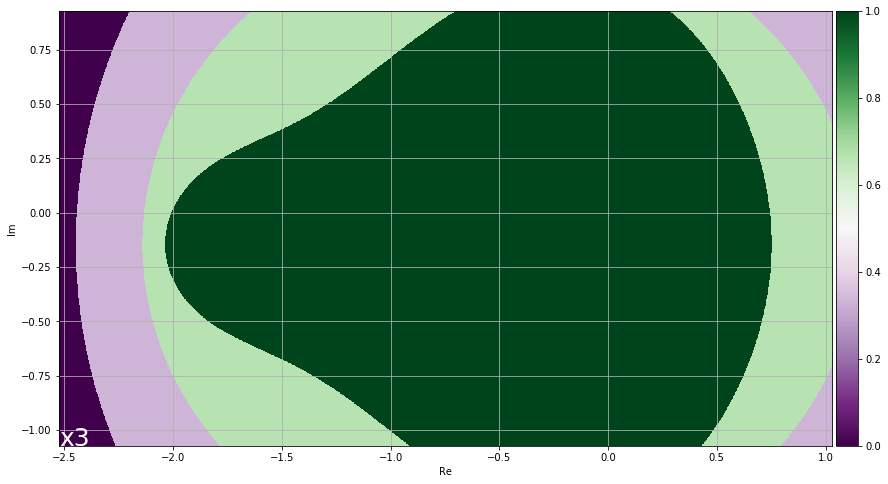

time to compute 3 iterations: 7.89491987228s


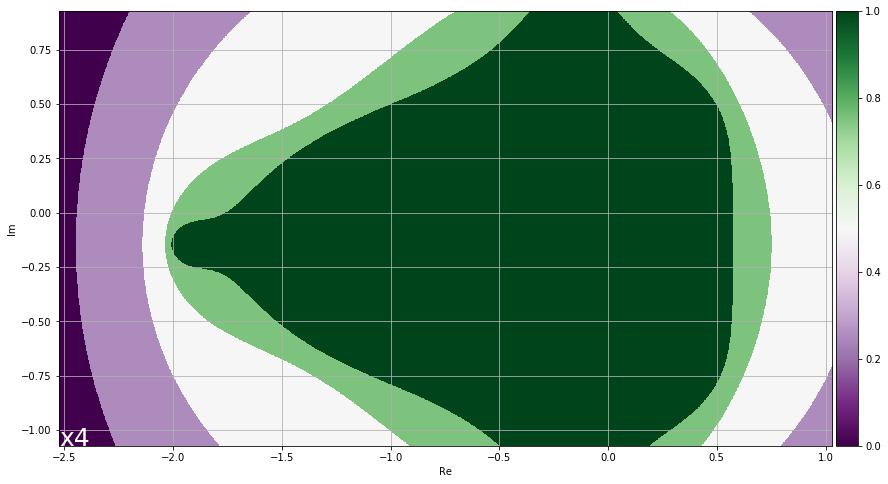

time to compute 4 iterations: 8.67185401917s


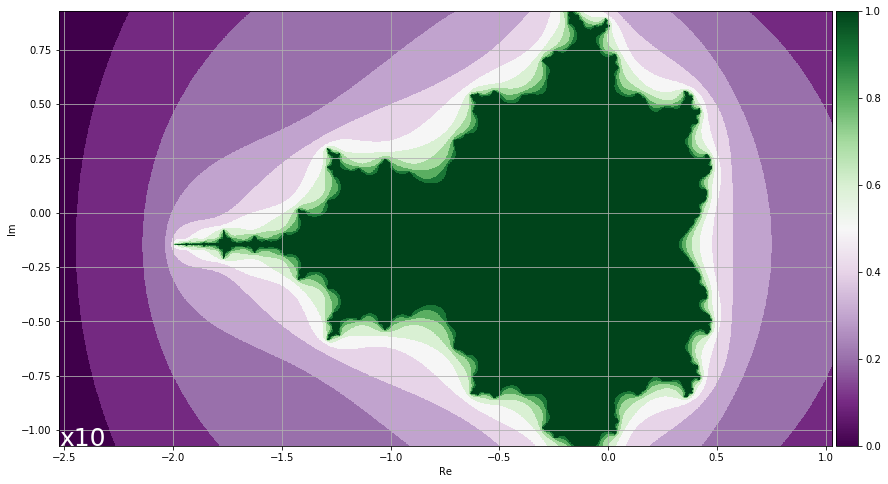

time to compute 10 iterations: 11.0411579609s


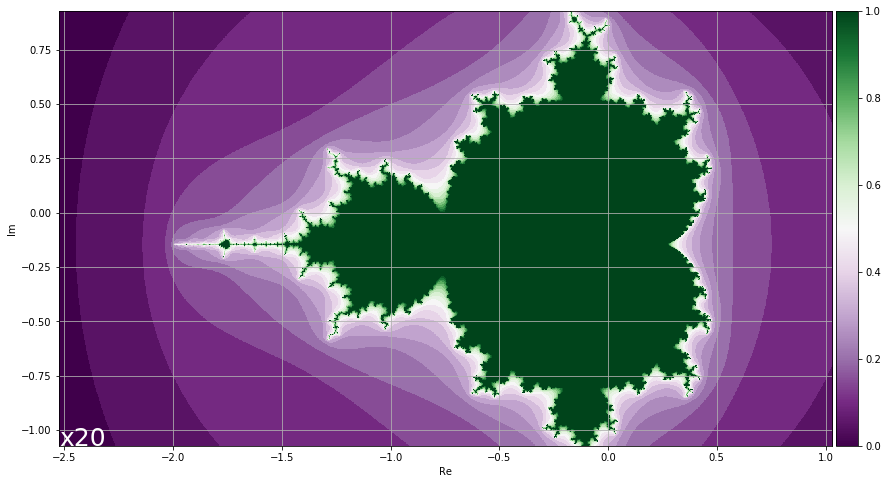

time to compute 20 iterations: 14.1163511276s


In [10]:
def print_example(Z = 1, resx = 1920, resy = 1080):
    ZOOM       = 1/float(Z)
    ratio      = float(resx)/float(resy)
    X, Y       = -0.74814501, -0.071673006
    
    if Z > 20:
        Z = Z/10
        XMIN, XMAX = X-ZOOM*ratio, X+ZOOM*ratio
        YMIN, YMAX = Y-ZOOM, Y+ZOOM        
    else:
        XMIN, XMAX = X-1.*ratio, X+1.*ratio
        YMIN, YMAX = Y-1., Y+1.

    plt.figure(figsize = (16,8))
    image = np.zeros((resy,resx))
    
    image = draw_Mandel(XMIN, XMAX, YMIN, YMAX, image, Z,6)
    
    #np.save("mandelbrot",image)
    p2, p98 = np.percentile(image, (2, 98))
    im = plt.imshow(exposure.rescale_intensity(image, in_range=(p2, p98)), cmap ="PRGn", extent=[XMIN, XMAX,YMIN, YMAX])
    plt.colorbar(im,fraction=0.046, pad=0.005)
    plt.ylabel("Im")
    plt.xlabel("Re")
    plt.grid()
    plt.text(XMIN,YMIN, "x"+str(Z), fontsize = 25, color = "w")
    plt.show()

timesCPU = []
for i in [1,2,3,4,10,20]:
    start = timer()
    print_example(i)
    dt = timer() - start
    print "time to compute "+str(i)+" iterations: "+str(dt)+"s"
    timesCPU.append(dt)

Let's stop after 20 iterations and lets plot the times it takes to compute each set of iterations. This appears to take very long for long eterations. The plot below shows the time per set.

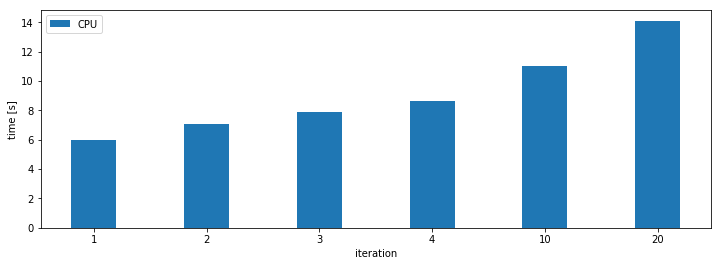

In [11]:
bar_width = 0.4
plt.figure(figsize = (12,4))
plt.bar(np.arange(len(timesCPU)), timesCPU,bar_width,label = "CPU")
plt.xticks(np.arange(len(timesCPU)), [1,2,3,4,10,20])
plt.legend()
plt.xlabel("iteration")
plt.ylabel("time [s]")
plt.show()

## Compute on the GPU

To optimise and speed up the computation, we can use numba's autojit and hope that it utelises the GPU. 

In [12]:
@autojit
def Mandel(x,y, itter = 1, thresh = 4):
    c = complex(x,y)
    z = 0.0j
    
    for i in range(itter):

        z = z**2+c
        if (z.real**2. + z.imag**2) >=thresh:
            return i
        
    return itter

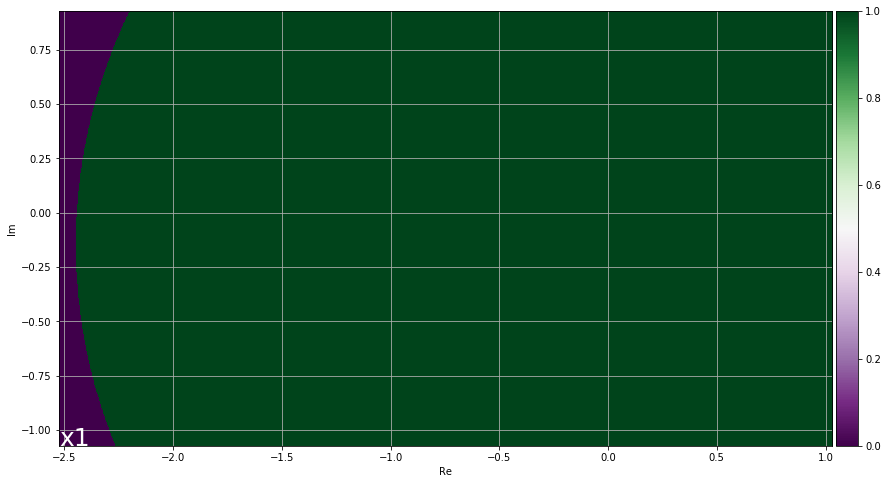

time to compute 1 iterations: 2.46595406532s


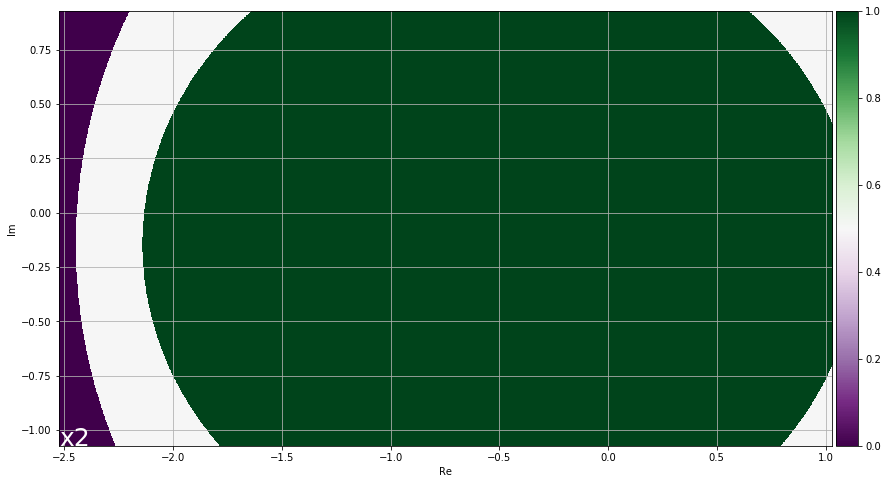

time to compute 2 iterations: 2.12643885612s


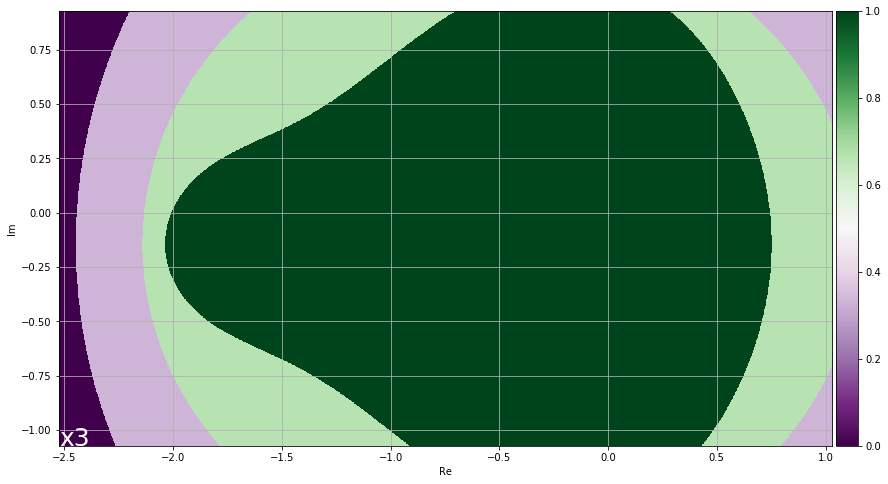

time to compute 3 iterations: 2.11809420586s


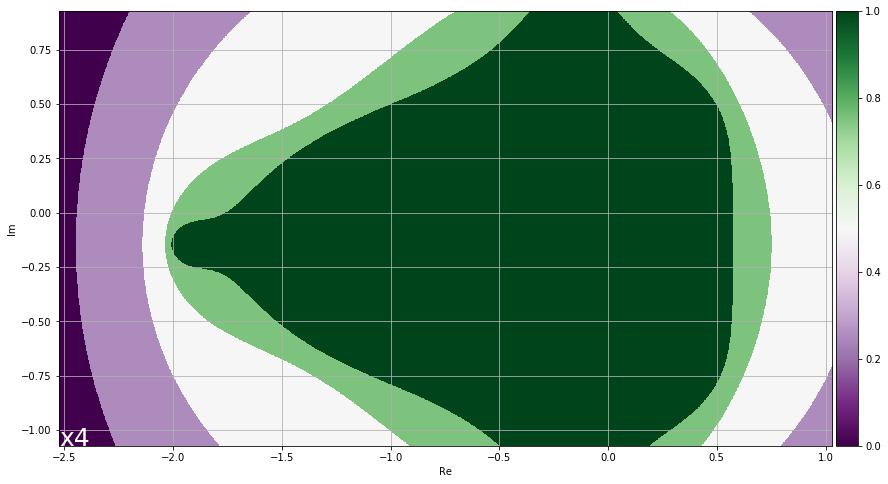

time to compute 4 iterations: 2.08105397224s


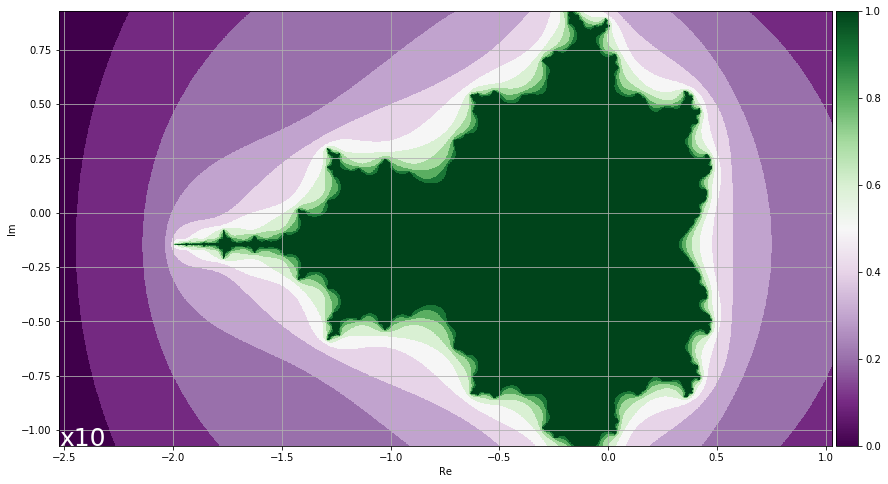

time to compute 10 iterations: 2.21474909782s


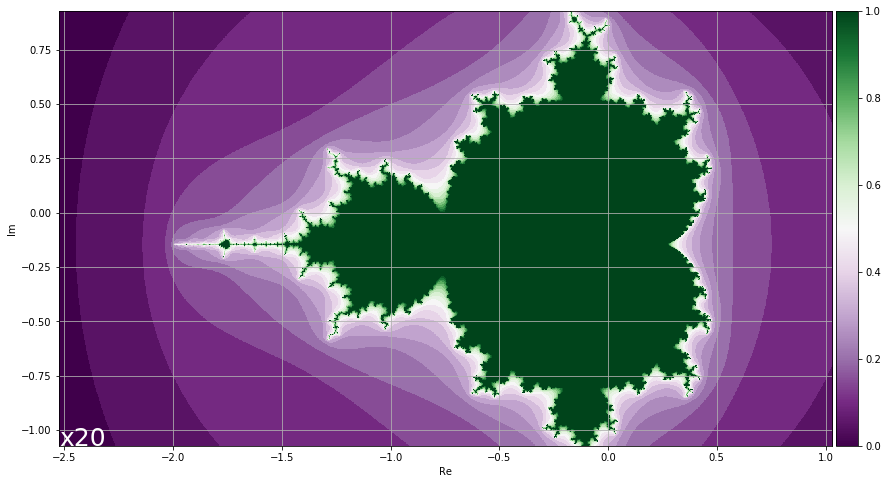

time to compute 20 iterations: 2.22447109222s


/usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/skimage/exposure/exposure.py:297: RuntimeWarning: invalid value encountered in true_divide
  image = (image - imin) / float(imax - imin)


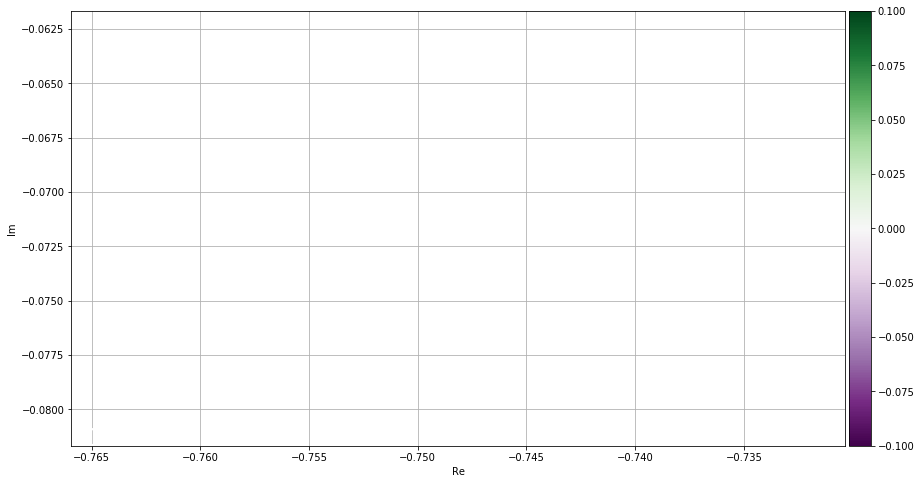

time to compute 100 iterations: 2.32866287231s


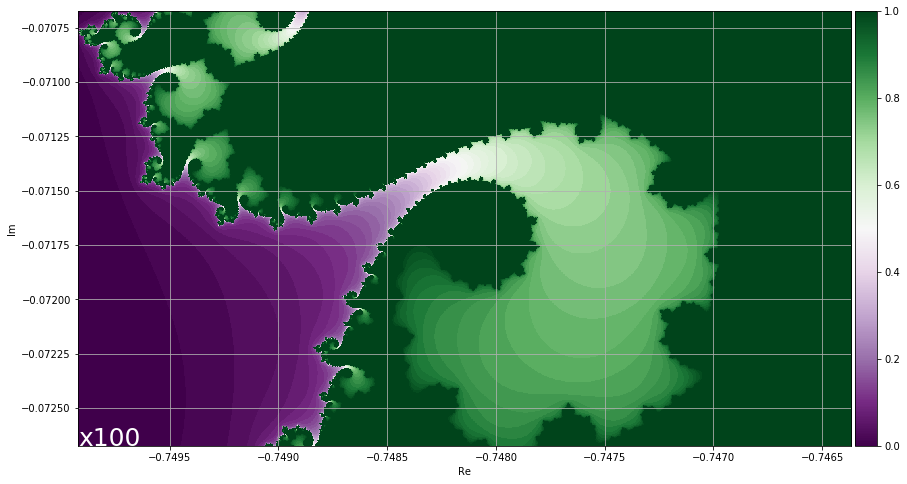

time to compute 1000 iterations: 2.90682005882s


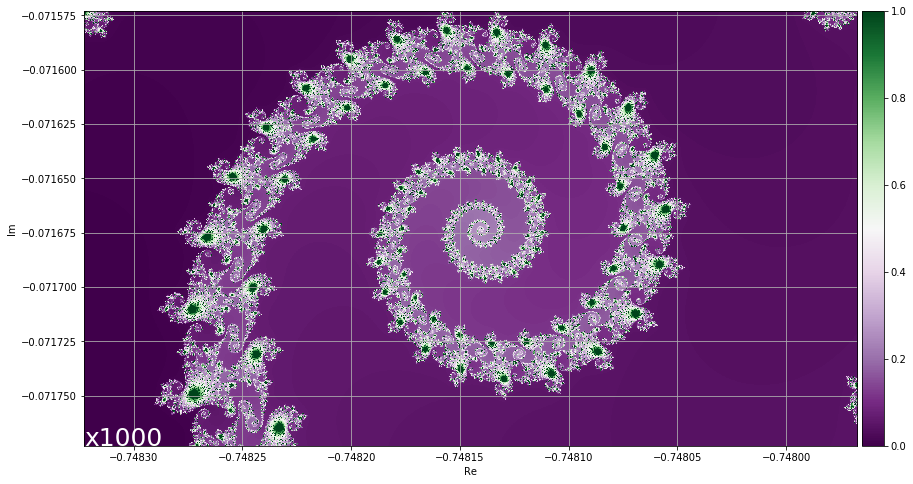

time to compute 10000 iterations: 4.09239888191s


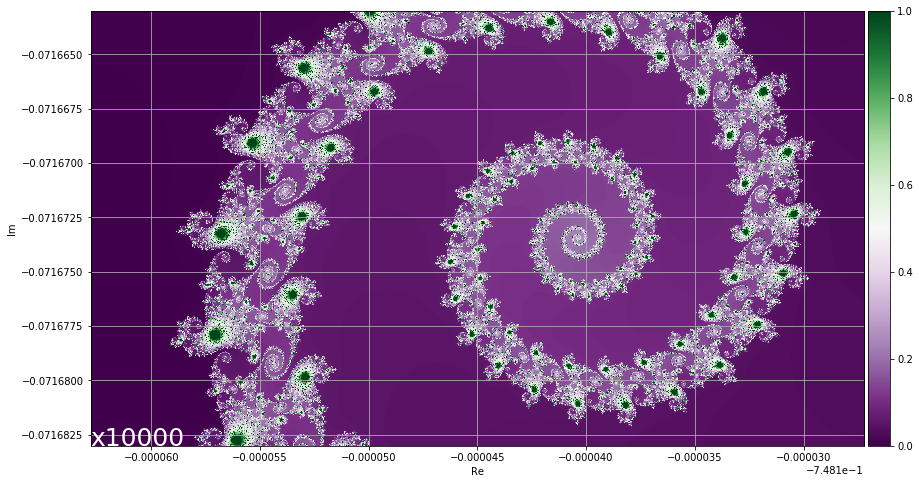

time to compute 100000 iterations: 5.55894207954s


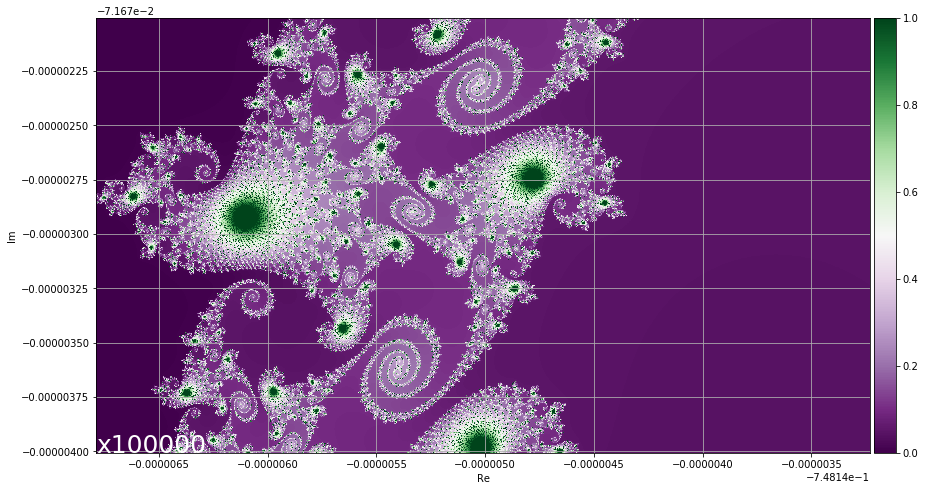

time to compute 1000000 iterations: 6.11377596855s


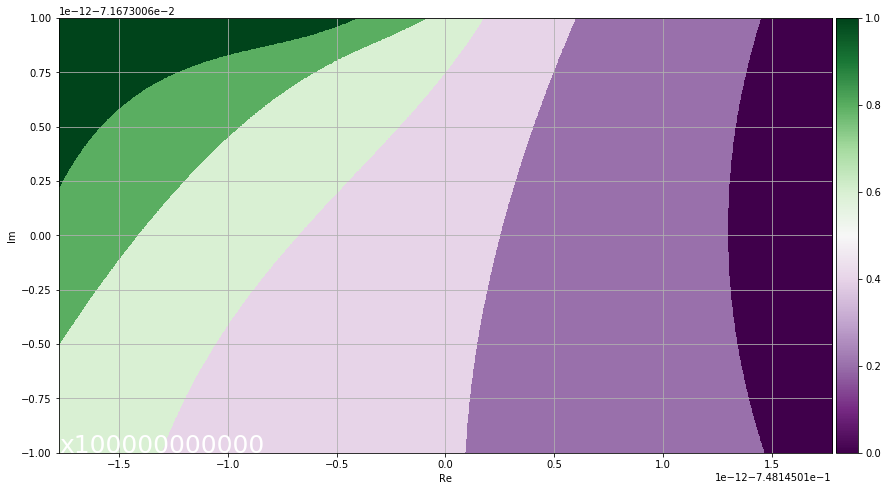

time to compute 1000000000000 iterations: 13.4965660572s


In [13]:
def print_example(Z = 1, resx = 1920, resy = 1080):
    ZOOM       = 1/float(Z)
    ratio      = float(resx)/float(resy)
    X, Y       = -0.74814501, -0.071673006
    
    if Z > 20:
        Z = Z/10
        XMIN, XMAX = X-ZOOM*ratio, X+ZOOM*ratio
        YMIN, YMAX = Y-ZOOM, Y+ZOOM        
    else:
        XMIN, XMAX = X-1.*ratio, X+1.*ratio
        YMIN, YMAX = Y-1., Y+1.

    plt.figure(figsize = (16,8))
    image = np.zeros((resy,resx))
    
    image = draw_Mandel(XMIN, XMAX, YMIN, YMAX, image, Z,6)
    
    #np.save("mandelbrot",image)
    p2, p98 = np.percentile(image, (2, 98))
    im = plt.imshow(exposure.rescale_intensity(image, in_range=(p2, p98)), cmap ="PRGn", extent=[XMIN, XMAX,YMIN, YMAX])
    plt.colorbar(im,fraction=0.046, pad=0.005)
    plt.ylabel("Im")
    plt.xlabel("Re")
    plt.grid()
    plt.text(XMIN,YMIN, "x"+str(Z), fontsize = 25, color = "w")
    plt.show()

timesGPU = []
for i in [1,2,3,4,10,20,100,1000,10000,100000,1000000,1000000000000]:
    start = timer()
    print_example(i)
    dt = timer() - start
    print "time to compute "+str(i)+" iterations: "+str(dt)+"s"
    timesGPU.append(dt)

Let's compare the the previous CPU iterations with the optimised GPU iterations. We can see that 

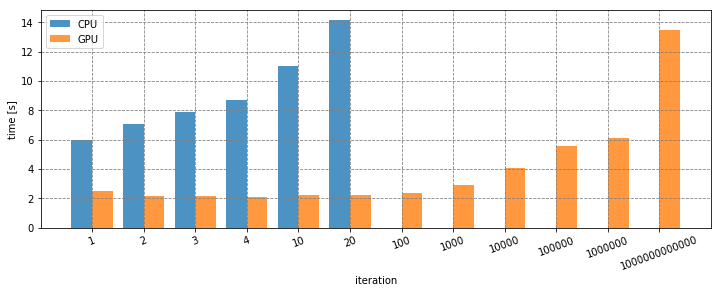

In [14]:
bar_width = 0.4
plt.figure(figsize = (12,4))
plt.grid(color='gray', linestyle='dashed')
plt.bar(np.arange(len(timesCPU))-bar_width/2., timesCPU, bar_width, label = "CPU", alpha = 0.8)
plt.bar(np.arange(len(timesGPU))+bar_width/2., timesGPU, bar_width, label = "GPU", alpha = 0.8)
plt.xticks(np.arange(len(timesGPU)), [1,2,3,4,10,20,100,1000,10000,100000,1000000,1000000000000], rotation=20)

plt.legend()
plt.xlabel("iteration")
plt.ylabel("time [s]")
plt.show()

Further we can make a small video zooming in on the fractal as follows:

In [ ]:
def save_frame(Z = 1,save = 1, resx = 1920, resy = 1080):
    
    ZOOM       = 1/float(Z)
    ratio      = float(resx)/float(resy)
    X, Y       = -0.74814501, -0.071673006
    XMIN, XMAX = X-ZOOM*ratio, X+ZOOM*ratio
    YMIN, YMAX = Y-ZOOM, Y+ZOOM

    image = np.zeros((resy,resx))
    image = draw_Mandel(XMIN, XMAX, YMIN, YMAX, image, (Z+2000)/100,6)

    p2, p98 = np.percentile(image, (2, 98))
    
    image  =  exposure.rescale_intensity(image, in_range=(p2, p98))
    Iimage = (((image-image.min()).astype(float)/float((image-image.min()).max()))*255.).astype("uint8")
    grey   = Image.fromarray(Iimage)
    grey.save("/media/unknown/DATA1/temp/"+str(10000000000+save)+".jpg",optimize=True,quality=100)
    return image

frames = []
times  = []
n = 1
#for i in [1,100,1000,10000, 100000, 1000000]:
for i in np.linspace(1,10,2000)**10:
    start = timer()
    frames.append(save_frame(i,n))
    times.append(timer() - start)
    n = n+1
print "Finished in "+str(np.sum(times))